# Intro

This notebook visualizes the prediction results from all models after training.

# Load libs

In [255]:
import pandas as pd
import numpy as np
import plotly.express as px
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

In [256]:
%load_ext kedro.ipython

The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython


In [270]:
%reload_kedro

[07/08/24 15:57:02] INFO     Resolved project path as: /home/filip/projects/science/hexgin.         ]8;id=446812;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=40513;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/ipython/__init__.py#171\171]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[07/08/24 15:57:03] INFO     Kedro project HexGIN                                                   ]8;id=857887;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=556743;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/ipython/__init__.py#141\141]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=899521;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=531668;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/ipython/__init__.py#142\142]8;;\
                             'pipelines'                                                                           

                    WARNING  Failed to load kedro_viz.launchers.jupyter commands from                  ]8;id=668215;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/framework/cli/utils.py\utils.py]8;;\:]8;id=477252;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/framework/cli/utils.py#379\379]8;;\
                             EntryPoint(name='line_magic',                                                         
                             value='kedro_viz.launchers.jupyter:run_viz', group='kedro.line_magic').               
                             Full exception: No module named 'toposort'                                            

# Data load


In [271]:
cv_metrics = catalog.load("crossval_metrics")
bootstrap_metrics = catalog.load("bootstrap_metrics")

                    INFO     Loading data from crossval_metrics (CSVDataset)...                 ]8;id=426019;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=186102;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/io/data_catalog.py#508\508]8;;\

                    INFO     Loading data from bootstrap_metrics (CSVDataset)...                ]8;id=580854;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=437806;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/io/data_catalog.py#508\508]8;;\

In [272]:
melted_data = cv_metrics.melt(id_vars=['model', 'fold'], value_vars=['precision', 'f1', 'recall', 'rocauc'], var_name='metric')

In [273]:
melted_data.groupby(['model', 'metric']).agg({'value': ['mean', 'median', 'std']}).T

model           HexGIN                                     MLP            \
metric              f1 precision    recall    rocauc        f1 precision   
value mean    0.792044  0.758540  0.862283  0.883033  0.735438  0.716630   
      median  0.808782  0.730041  0.939746  0.894823  0.738052  0.720579   
      std     0.048371  0.078770  0.145182  0.034376  0.067724  0.092141   

model                                 SAGE                                
metric          recall    rocauc        f1 precision    recall    rocauc  
value mean    0.791036  0.819942  0.745951  0.671691  0.876152  0.815418  
      median  0.790698  0.821438  0.752708  0.638061  0.939746  0.820354  
      std     0.156644  0.059732  0.034624  0.080415  0.135344  0.034656

In [274]:
writer = pd.ExcelWriter("bottstrapped_metrics_stats.xlsx")

In [275]:
melted_data.groupby(['model', 'metric']).agg({'value': ['mean', 'median', 'std']}).T.round(3).to_excel(writer, sheet_name='overall_results')

# Bootstrap metrics

In [276]:
sort_dict = {'HexGIN': 1, 'SAGE': 2, 'MLP': 3}
bootstrap_metrics.sort_values(by=['model'], ascending=True, inplace=True, key=lambda x: x.map(sort_dict))
bootstrap_metrics.round(4)

,model,metric,CI low,CI high
0,HexGIN,f1,0.7774,0.8048
1,HexGIN,precision,0.7370,0.7814
2,HexGIN,recall,0.8183,0.9015
3,HexGIN,rocauc,0.8729,0.8922
4,SAGE,f1,0.7355,0.7545
5,SAGE,precision,0.6501,0.6958
6,SAGE,recall,0.8343,0.9126
7,SAGE,rocauc,0.8058,0.8243
8,MLP,f1,0.7159,0.7542
9,MLP,precision,0.6911,0.7414


In [277]:
bootstrap_metrics.round(4).to_excel(writer, sheet_name='bootstrap_results')
writer.close()

In [278]:
def plot_confidence_interval(x, ci_lo, ci_hi, ax, color='#2187bb', horizontal_line_width=0.6):
    mean = (ci_lo + ci_hi) / 2.
    

    left = x - horizontal_line_width / 2
    right = x + horizontal_line_width / 2
    ax.plot([x, x], [ci_lo, ci_hi], color=color)
    ax.plot([left, right], [ci_hi, ci_hi], color=color)
    ax.plot([left, right], [ci_lo, ci_lo], color=color)
    ax.plot(x, mean, 'o', color='#f44336')

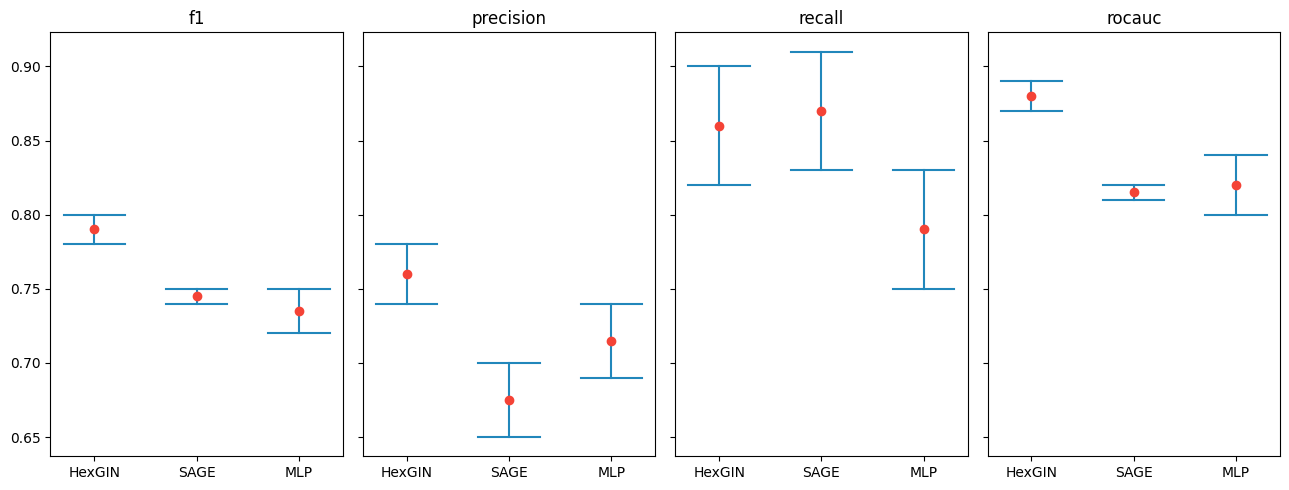

In [279]:
metrics = ['f1', 'precision', 'recall', 'rocauc']
f, axs = plt.subplots(1, len(metrics), figsize=(13, 5), sharey=True, sharex=True, layout='tight')
plt.subplots_adjust(wspace=0.5)
for i, metric in enumerate(metrics):
    ci_low = bootstrap_metrics.loc[bootstrap_metrics.metric == metric, 'CI low'].round(2)
    ci_hi = bootstrap_metrics.loc[bootstrap_metrics.metric == metric, 'CI high'].round(2)

    plt.xticks([0, 1, 2], ['HexGIN', 'SAGE', 'MLP'])
    ax = axs[i]
    plot_confidence_interval(0, ci_low.iloc[0], ci_hi.iloc[0], ax)
    plot_confidence_interval(1, ci_low.iloc[1], ci_hi.iloc[1], ax)
    plot_confidence_interval(2, ci_low.iloc[2], ci_hi.iloc[2], ax)
    ax.set_title(metric)
plt.show()

# Test metrics

In [280]:
hexgin_test_metrics = catalog.load("hexgin_test_report")
sage_test_metrics = catalog.load("sage_test_report")
mlp_test_metrics = catalog.load("mlp_test_report")

[07/08/24 15:57:16] INFO     Loading data from hexgin_test_report (CSVDataset)...               ]8;id=844461;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=638031;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/io/data_catalog.py#508\508]8;;\

                    INFO     Loading data from sage_test_report (CSVDataset)...                 ]8;id=242927;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=638003;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/io/data_catalog.py#508\508]8;;\

                    INFO     Loading data from mlp_test_report (CSVDataset)...                  ]8;id=840680;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=327603;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/io/data_catalog.py#508\508]8;;\

In [281]:
hexgin_test_metrics = catalog.load("hexgin_metrics")
sage_test_metrics = catalog.load("sage_metrics")
mlp_test_metrics = catalog.load("mlp_metrics")

                    INFO     Loading data from hexgin_metrics (CSVDataset)...                   ]8;id=403429;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=634928;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/io/data_catalog.py#508\508]8;;\

                    INFO     Loading data from sage_metrics (CSVDataset)...                     ]8;id=203305;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=160457;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/io/data_catalog.py#508\508]8;;\

                    INFO     Loading data from mlp_metrics (CSVDataset)...                      ]8;id=229255;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=902898;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/io/data_catalog.py#508\508]8;;\

In [282]:
pd.concat([hexgin_test_metrics, sage_test_metrics, mlp_test_metrics], axis=0).round(3).reset_index(drop=True).style.highlight_max(
    axis=0,
    color='lightgreen',
    subset=['f1', 'precision', 'recall', 'rocauc'])

,f1,precision,recall,rocauc,model
0,0.720000,0.855000,0.622000,0.802000,HexGIN
1,0.678000,0.845000,0.566000,0.787000,SAGE
2,0.594000,0.718000,0.507000,0.695000,MLP
